# quant-econ Solutions: Default Risk and Income Fluctuations

Solutions for http://quant-econ.net/jl/arellano.html

In [1]:
using QuantEcon, QuantEcon.Models
using Gadfly

Compute the value function, policy and equilibrium prices

In [2]:
ae = ArellanoEconomy(β=.953,     # time discount rate
                     γ=2.,       # risk aversion
                     r=0.017,    # international interest rate
                     ρ=.945,     # persistence in output 
                     η=0.025,    # st dev of output shock
                     θ=0.282,    # prob of regaining access 
                     ny=21,      # number of points in y grid
                     nB=251)     # number of points in B grid

# now solve the model on the grid. 
vfi!(ae)

Finished iteration 25 with dist of 0.3424484168091375
Finished iteration 50 with dist of 0.09820394074288785
Finished iteration 75 with dist of 0.02915866229151476
Finished iteration 100 with dist of 0.008729266837651295
Finished iteration 125 with dist of 0.002618400938121823
Finished iteration 150 with dist of 0.0007857709211762653
Finished iteration 175 with dist of 0.00023583246008485048
Finished iteration 200 with dist of 7.078195654486308e-5
Finished iteration 225 with dist of 2.1244388765495614e-5
Finished iteration 250 with dist of 6.3762679332057814e-6
Finished iteration 275 with dist of 1.9137668516577833e-6
Finished iteration 300 with dist of 5.743961750681592e-7
Finished iteration 325 with dist of 1.7239873884022927e-7
Finished iteration 350 with dist of 5.174360495630026e-8
Finished iteration 375 with dist of 1.5530289942944364e-8


Compute the bond price schedule as seen in figure 3 of Arellano (2008)

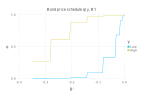

In [3]:
# Create "Y High" and "Y Low" values as 5% devs from mean
high, low = mean(ae.ygrid)*1.05, mean(ae.ygrid)*.95
iy_high, iy_low = map(x->searchsortedfirst(ae.ygrid, x), (high, low))

# Extract a suitable plot grid
x = Float64[]
q_low = Float64[]
q_high = Float64[]
for i=1:ae.nB
    b = ae.Bgrid[i]
    if -0.35 <= b <= 0  # To match fig 3 of Arellano
        push!(x, b)
        push!(q_low, ae.q[i, iy_low])
        push!(q_high, ae.q[i, iy_high])
    end
end

# generate plot
plot(x=repeat(x, outer=[2]), y=[q_low; q_high], 
     color=repeat([:Low, :High], inner=[length(x)]),
     Guide.title("Bond price schedule q(y, B')"),
     Guide.xlabel("B'"), Guide.ylabel("q"),
     Guide.colorkey("y"), Geom.line)

Draw a plot of the value functions

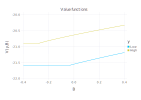

In [4]:
plot(x=repeat(ae.Bgrid, outer=[2]), 
     y=vec(ae.vf[:, [iy_low, iy_high]]),
     color=repeat([:Low, :High], inner=[length(ae.Bgrid)]),
     Guide.title("Value functions"),
     Guide.xlabel("B"), Guide.ylabel("V(y,B)"),
     Guide.colorkey("y"), Geom.line)

Draw a heat map for default probability

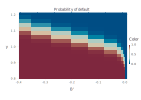

In [5]:
plot(x_min=repeat(ae.Bgrid[1:end-1], inner=[ae.ny-1]),
     x_max=repeat(ae.Bgrid[2:end], inner=[ae.ny-1]),
     y_min=repeat(ae.ygrid[1:end-1], outer=[ae.nB-1]),
     y_max=repeat(ae.ygrid[2:end], outer=[ae.nB-1]),
     color=clamp(vec(ae.defprob[1:end-1, 1:end-1]'), 0, 1), 
     Geom.rectbin,
     Guide.xlabel("B'"), Guide.ylabel("y"), 
     Guide.title("Probability of default"), Geom.rectbin,
     Scale.y_continuous(minvalue=0.8, maxvalue=1.2),
     Scale.x_continuous(minvalue=minimum(ae.Bgrid), maxvalue=0.0),
     Scale.color_continuous(minvalue=0, maxvalue=1))

Plot a time series of major variables simulated from the model.

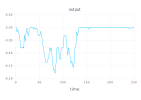

In [63]:
# simulate
T = 250
y_vec, B_vec, q_vec, default_vec = simulate(ae, T)

# find starting and ending periods of recessions (if any)
if any(default_vec)
    defs = find(default_vec)
    def_breaks = diff(defs) .> 1
    starts = defs[[true; def_breaks]]
    ends = defs[[def_breaks; true]]
else
    starts, ends = Int[], Int[]
end

#-Plots-#

p1 = plot(
    layer(x=1:T,y=y_vec,Geom.line),
    Guide.title("output"),
    Guide.xlabel("time"),
    Guide.ylabel("")
)

#-Python Target-#

# plot_series = y_vec, B_vec, q_vec
# titles = 'output', 'foreign assets', 'bond price'

# fig, axes = plt.subplots(len(plot_series), 1, figsize=(10, 12))
# p_args = {'lw': 2, 'alpha': 0.7}
# fig.subplots_adjust(hspace=0.3)

# for ax, series, title in zip(axes, plot_series, titles):
#     # determine suitable y limits
#     s_max, s_min = max(series), min(series)
#     s_range = s_max - s_min
#     y_max = s_max + s_range * 0.1
#     y_min = s_min - s_range * 0.1
#     ax.set_ylim(y_min, y_max)
#     for pair in start_end_pairs:
#         ax.fill_between(pair, (y_min, y_min), (y_max, y_max), color='k', alpha=0.3)
        
#     ax.grid()
#     ax.set_title(title)
#     ax.plot(range(T), series, **p_args)
#     ax.set_xlabel(r"time")

# plt.show()

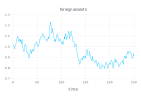

In [64]:
p2 = plot(   
    x=1:T,
    y=B_vec,
    Geom.line,
    Guide.title("foreign assests"),
    Guide.xlabel("time"),
    Guide.ylabel("")
    )

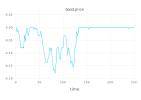

In [65]:
p3 = plot(   
        x=1:T,
        y=y_vec,
        Geom.line,
        Guide.title("bond price"),
        Guide.xlabel("time"),
Guide.ylabel("")
    )